# Model Evaluation Notebook

This notebook evaluates the performance of both next activity prediction and suffix prediction models by:
1. Loading the original filtered event log
2. Generating traces using both models
3. Comparing generated traces against the original log using various metrics:
   - Activity distribution
   - Case length distribution
   - Activity sequence patterns
   - END token prediction accuracy
   - Trace similarity metrics


## 1. Setup and Imports


In [2]:
import sys
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Dict, Tuple

# Add project root to Python path
project_root = Path.cwd().parent if Path.cwd().name == 'next_activity_prediction' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

from next_activity_prediction import LSTMNextActivityPredictor, LSTMSuffixPredictor
from next_activity_prediction.data_preprocessing import load_event_log, filter_lifecycles, extract_case_sequences

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


d:\Repos\process-simulation-engine-1\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 2. Configuration

Set paths to models and event log.


In [3]:
# Paths
EVENT_LOG_PATH = r"..\eventlog\eventlog.xes.gz"  # Original event log
NEXT_ACTIVITY_MODEL_PATH = "models/next_activity_lstm"  # Next activity model directory
SUFFIX_MODEL_PATH = "models/suffix_prediction_lstm"  # Suffix prediction model directory

# Evaluation parameters
NUM_TRACES_TO_GENERATE = 1000  # Number of traces to generate for evaluation
MAX_CASE_LENGTH = 200  # Maximum case length to prevent infinite loops

print("Configuration:")
print(f"  Event log: {EVENT_LOG_PATH}")
print(f"  Next activity model: {NEXT_ACTIVITY_MODEL_PATH}")
print(f"  Suffix model: {SUFFIX_MODEL_PATH}")
print(f"  Traces to generate: {NUM_TRACES_TO_GENERATE}")


Configuration:
  Event log: ..\eventlog\eventlog.xes.gz
  Next activity model: models/next_activity_lstm
  Suffix model: models/suffix_prediction_lstm
  Traces to generate: 1000


## 3. Load Original Event Log

Load and filter the original event log to get the ground truth traces.


In [4]:
# Load and filter original event log
print("Loading original event log...")
df_original = load_event_log(EVENT_LOG_PATH)
df_filtered = filter_lifecycles(df_original)

# Extract case sequences
original_sequences = extract_case_sequences(df_filtered, min_length=2, max_length=MAX_CASE_LENGTH)

print(f"\nOriginal event log statistics:")
print(f"  Total cases: {len(original_sequences)}")
print(f"  Average case length: {np.mean([len(s) for s in original_sequences]):.2f}")
print(f"  Min/Max case length: {min(len(s) for s in original_sequences)}/{max(len(s) for s in original_sequences)}")

# Remove END tokens for comparison (they're not in original sequences before we added them)
original_sequences_clean = [seq[:-1] if seq[-1] == "END" else seq for seq in original_sequences]

print(f"\nAfter removing END tokens:")
print(f"  Average case length: {np.mean([len(s) for s in original_sequences_clean]):.2f}")


2026-01-09 16:04:00,076 - next_activity_prediction.data_preprocessing - INFO - Loading event log from ..\eventlog\eventlog.xes.gz


Loading original event log...


d:\Repos\process-simulation-engine-1\.venv\Lib\site-packages\pm4py\utils.py:987: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")
2026-01-09 16:04:08,420 - next_activity_prediction.data_preprocessing - INFO - Loaded 1202267 events, 31509 cases
2026-01-09 16:04:08,572 - next_activity_prediction.data_preprocessing - INFO - Filtered to start/complete lifecycles: 1,202,267 -> 603,533 (50.2%)
2026-01-09 16:04:09,693 - next_activity_prediction.data_preprocessing - INFO - Extracted 31509 case sequences
2026-01-09 16:04:09,696 - next_activity_prediction.data_preprocessing - INFO - Average sequence length: 20.2 (including END)
2026-01-09 16:04:09,699 - next_activity_prediction.data_p


Original event log statistics:
  Total cases: 31509
  Average case length: 20.15
  Min/Max case length: 9/68

After removing END tokens:
  Average case length: 19.15


## 4. Load Models

Load both prediction models.


In [5]:
# Load next activity predictor
print("Loading next activity predictor...")
try:
    next_activity_predictor = LSTMNextActivityPredictor(model_path=NEXT_ACTIVITY_MODEL_PATH)
    print(f"✓ Next activity predictor loaded")
    print(f"  Vocabulary size: {len(next_activity_predictor.activity_to_idx)}")
    print(f"  END token index: {next_activity_predictor.end_token_idx}")
except Exception as e:
    print(f"✗ Failed to load next activity predictor: {e}")
    next_activity_predictor = None

# Load suffix predictor
print("\nLoading suffix predictor...")
try:
    suffix_predictor = LSTMSuffixPredictor(model_path=SUFFIX_MODEL_PATH)
    print(f"✓ Suffix predictor loaded")
    print(f"  Vocabulary size: {len(suffix_predictor.activity_to_idx)}")
    print(f"  Prefix length: {suffix_predictor.prefix_length}")
    print(f"  Suffix length: {suffix_predictor.suffix_length}")
except Exception as e:
    print(f"✗ Failed to load suffix predictor: {e}")
    suffix_predictor = None


Loading next activity predictor...


2026-01-09 16:04:10,022 - next_activity_prediction.predictor - INFO - Loaded LSTMNextActivityPredictor from models/next_activity_lstm
2026-01-09 16:04:10,023 - next_activity_prediction.predictor - INFO - Vocabulary size: 28 (including END)
2026-01-09 16:04:10,023 - next_activity_prediction.predictor - INFO - Sequence length: 50
2026-01-09 16:04:10,024 - next_activity_prediction.predictor - INFO - END token index: 27
2026-01-09 16:04:10,025 - next_activity_prediction.suffix_predictor - INFO - Loading suffix prediction model from models/suffix_prediction_lstm...


✓ Next activity predictor loaded
  Vocabulary size: 28
  END token index: 27

Loading suffix predictor...


2026-01-09 16:04:10,269 - next_activity_prediction.suffix_predictor - INFO - Loaded suffix prediction model
2026-01-09 16:04:10,270 - next_activity_prediction.suffix_predictor - INFO - Prefix length: 50, Suffix length: 30
2026-01-09 16:04:10,270 - next_activity_prediction.suffix_predictor - INFO - Vocabulary size: 28
2026-01-09 16:04:10,270 - next_activity_prediction.suffix_predictor - INFO - END token index: 27


✓ Suffix predictor loaded
  Vocabulary size: 28
  Prefix length: 50
  Suffix length: 30


## 5. Generate Traces

Generate traces using both models.


In [6]:
class MockCaseState:
    """Mock case state for trace generation."""
    def __init__(self, case_id, activity_history):
        self.case_id = case_id
        self.activity_history = activity_history

def generate_trace(predictor, case_id: str, max_length: int = MAX_CASE_LENGTH) -> List[str]:
    """
    Generate a complete trace using a predictor.
    
    Args:
        predictor: Next activity or suffix predictor
        case_id: Case identifier
        max_length: Maximum trace length to prevent infinite loops
        
    Returns:
        List of activity names (trace)
    """
    trace = []
    case_state = MockCaseState(case_id, [])
    
    for step in range(max_length):
        next_activity, is_end = predictor.predict(case_state)
        
        if is_end:
            # Add the final activity and break
            if next_activity not in ["END", "FAILED"]:
                trace.append(next_activity)
            break
        
        trace.append(next_activity)
        case_state.activity_history = trace.copy()
    
    # Reset predictor state for this case
    predictor.reset_case(case_id)
    
    return trace

# Generate traces with next activity predictor
print("Generating traces with next activity predictor...")
next_activity_traces = []
if next_activity_predictor:
    for i in range(NUM_TRACES_TO_GENERATE):
        case_id = f"next_activity_case_{i}"
        trace = generate_trace(next_activity_predictor, case_id, max_length=MAX_CASE_LENGTH)
        next_activity_traces.append(trace)
        if (i + 1) % 100 == 0:
            print(f"  Generated {i + 1}/{NUM_TRACES_TO_GENERATE} traces")
    print(f"✓ Generated {len(next_activity_traces)} traces")
else:
    print("✗ Skipping (model not loaded)")

# Generate traces with suffix predictor
print("\nGenerating traces with suffix predictor...")
suffix_traces = []
if suffix_predictor:
    for i in range(NUM_TRACES_TO_GENERATE):
        case_id = f"suffix_case_{i}"
        trace = generate_trace(suffix_predictor, case_id, max_length=MAX_CASE_LENGTH)
        suffix_traces.append(trace)
        if (i + 1) % 100 == 0:
            print(f"  Generated {i + 1}/{NUM_TRACES_TO_GENERATE} traces")
    print(f"✓ Generated {len(suffix_traces)} traces")
else:
    print("✗ Skipping (model not loaded)")


Generating traces with next activity predictor...
  Generated 100/1000 traces
  Generated 200/1000 traces
  Generated 300/1000 traces
  Generated 400/1000 traces
  Generated 500/1000 traces
  Generated 600/1000 traces
  Generated 700/1000 traces
  Generated 800/1000 traces
  Generated 900/1000 traces
  Generated 1000/1000 traces
✓ Generated 1000 traces

Generating traces with suffix predictor...
  Generated 100/1000 traces
  Generated 200/1000 traces
  Generated 300/1000 traces
  Generated 400/1000 traces
  Generated 500/1000 traces
  Generated 600/1000 traces
  Generated 700/1000 traces
  Generated 800/1000 traces
  Generated 900/1000 traces
  Generated 1000/1000 traces
✓ Generated 1000 traces


## 6. Compare Case Length Distributions

Compare the distribution of case lengths between original log and generated traces.


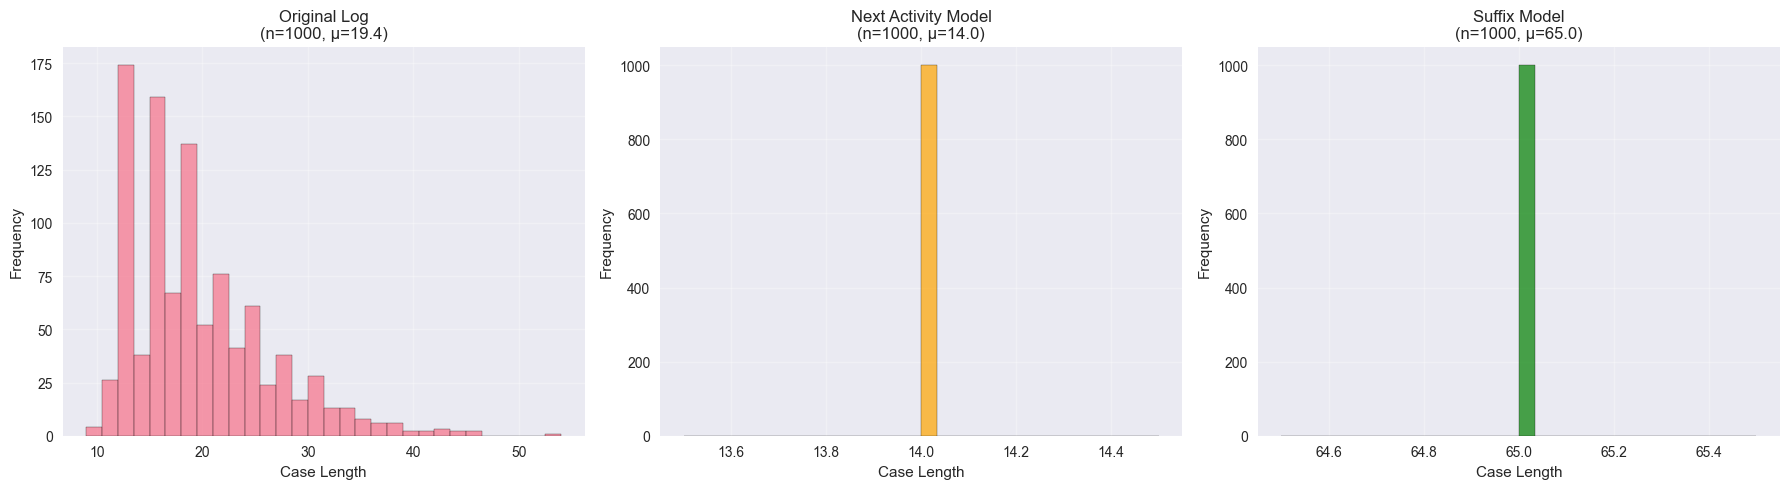

Case Length Statistics:

Original Log:
  Mean: 19.39
  Median: 18.00
  Std: 6.58
  Min/Max: 9/54

Next Activity Model:
  Mean: 14.00
  Median: 14.00
  Std: 0.00
  Min/Max: 14/14

Suffix Model:
  Mean: 65.00
  Median: 65.00
  Std: 0.00
  Min/Max: 65/65


In [7]:
# Calculate case lengths
original_lengths = [len(seq) for seq in original_sequences_clean[:NUM_TRACES_TO_GENERATE]]
next_activity_lengths = [len(trace) for trace in next_activity_traces] if next_activity_traces else []
suffix_lengths = [len(trace) for trace in suffix_traces] if suffix_traces else []

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
axes[0].hist(original_lengths, bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title(f'Original Log\n(n={len(original_lengths)}, μ={np.mean(original_lengths):.1f})')
axes[0].set_xlabel('Case Length')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Next Activity
if next_activity_lengths:
    axes[1].hist(next_activity_lengths, bins=30, alpha=0.7, edgecolor='black', color='orange')
    axes[1].set_title(f'Next Activity Model\n(n={len(next_activity_lengths)}, μ={np.mean(next_activity_lengths):.1f})')
    axes[1].set_xlabel('Case Length')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Model not loaded', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Next Activity Model')

# Suffix
if suffix_lengths:
    axes[2].hist(suffix_lengths, bins=30, alpha=0.7, edgecolor='black', color='green')
    axes[2].set_title(f'Suffix Model\n(n={len(suffix_lengths)}, μ={np.mean(suffix_lengths):.1f})')
    axes[2].set_xlabel('Case Length')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Model not loaded', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Suffix Model')

plt.tight_layout()
plt.show()

# Print statistics
print("Case Length Statistics:")
print(f"\nOriginal Log:")
print(f"  Mean: {np.mean(original_lengths):.2f}")
print(f"  Median: {np.median(original_lengths):.2f}")
print(f"  Std: {np.std(original_lengths):.2f}")
print(f"  Min/Max: {min(original_lengths)}/{max(original_lengths)}")

if next_activity_lengths:
    print(f"\nNext Activity Model:")
    print(f"  Mean: {np.mean(next_activity_lengths):.2f}")
    print(f"  Median: {np.median(next_activity_lengths):.2f}")
    print(f"  Std: {np.std(next_activity_lengths):.2f}")
    print(f"  Min/Max: {min(next_activity_lengths)}/{max(next_activity_lengths)}")

if suffix_lengths:
    print(f"\nSuffix Model:")
    print(f"  Mean: {np.mean(suffix_lengths):.2f}")
    print(f"  Median: {np.median(suffix_lengths):.2f}")
    print(f"  Std: {np.std(suffix_lengths):.2f}")
    print(f"  Min/Max: {min(suffix_lengths)}/{max(suffix_lengths)}")


## 7. Compare Activity Distributions

Compare the frequency of each activity in original log vs generated traces.


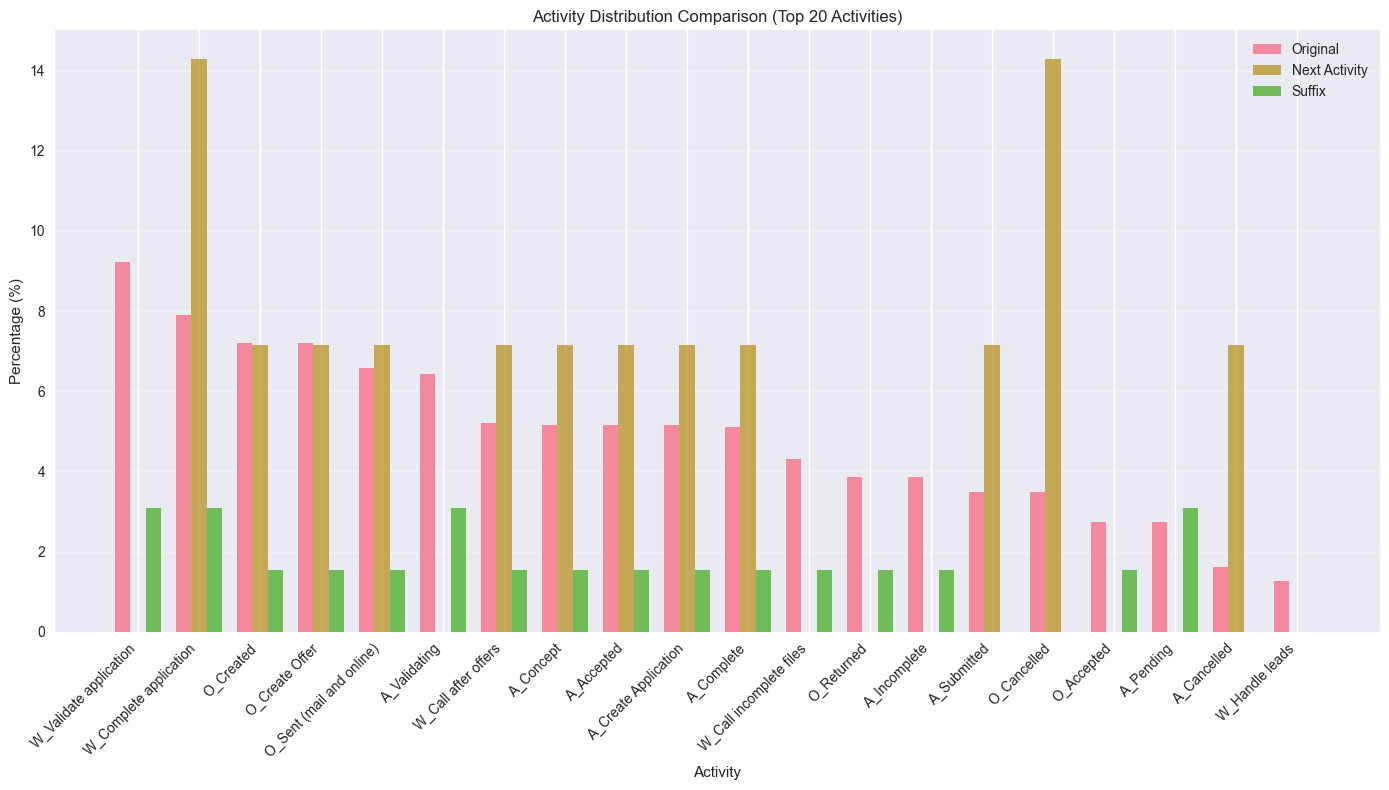


Top 20 Activities by Frequency:
                Activity  Original (%)  Next Activity (%)  Suffix (%)
  W_Validate application      9.212359           0.000000    3.076923
  W_Complete application      7.912519          14.285714    3.076923
               O_Created      7.211018           7.142857    1.538462
          O_Create Offer      7.211018           7.142857    1.538462
O_Sent (mail and online)      6.576572           7.142857    1.538462
            A_Validating      6.432145           0.000000    3.076923
     W_Call after offers      5.209677           7.142857    1.538462
               A_Concept      5.158096           7.142857    1.538462
              A_Accepted      5.158096           7.142857    1.538462
    A_Create Application      5.158096           7.142857    1.538462
              A_Complete      5.116831           7.142857    1.538462
 W_Call incomplete files      4.307010           0.000000    1.538462
              O_Returned      3.858256           0.000000

In [8]:
# Count activities
def count_activities(traces: List[List[str]]) -> Counter:
    """Count all activities across all traces."""
    all_activities = []
    for trace in traces:
        all_activities.extend(trace)
    return Counter(all_activities)

original_activity_counts = count_activities(original_sequences_clean[:NUM_TRACES_TO_GENERATE])
next_activity_counts = count_activities(next_activity_traces) if next_activity_traces else Counter()
suffix_counts = count_activities(suffix_traces) if suffix_traces else Counter()

# Get all unique activities
all_activities = set(original_activity_counts.keys())
if next_activity_traces:
    all_activities.update(next_activity_counts.keys())
if suffix_traces:
    all_activities.update(suffix_counts.keys())
all_activities = sorted(all_activities)

# Normalize to percentages
def normalize_counts(counter: Counter, total: int) -> Dict[str, float]:
    """Convert counts to percentages."""
    if total == 0:
        return {}
    return {act: (counter[act] / total) * 100 for act in all_activities}

total_original = sum(original_activity_counts.values())
total_next_activity = sum(next_activity_counts.values()) if next_activity_traces else 0
total_suffix = sum(suffix_counts.values()) if suffix_traces else 0

original_pct = normalize_counts(original_activity_counts, total_original)
next_activity_pct = normalize_counts(next_activity_counts, total_next_activity) if next_activity_traces else {}
suffix_pct = normalize_counts(suffix_counts, total_suffix) if suffix_traces else {}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Activity': all_activities,
    'Original (%)': [original_pct.get(act, 0) for act in all_activities],
    'Next Activity (%)': [next_activity_pct.get(act, 0) for act in all_activities] if next_activity_traces else [0] * len(all_activities),
    'Suffix (%)': [suffix_pct.get(act, 0) for act in all_activities] if suffix_traces else [0] * len(all_activities),
})

# Sort by original frequency
comparison_df = comparison_df.sort_values('Original (%)', ascending=False)

# Plot top activities
top_n = 20
top_activities = comparison_df.head(top_n)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_activities))
width = 0.25

ax.bar(x - width, top_activities['Original (%)'], width, label='Original', alpha=0.8)
if next_activity_traces:
    ax.bar(x, top_activities['Next Activity (%)'], width, label='Next Activity', alpha=0.8)
if suffix_traces:
    ax.bar(x + width, top_activities['Suffix (%)'], width, label='Suffix', alpha=0.8)

ax.set_xlabel('Activity')
ax.set_ylabel('Percentage (%)')
ax.set_title(f'Activity Distribution Comparison (Top {top_n} Activities)')
ax.set_xticks(x)
ax.set_xticklabels(top_activities['Activity'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print top activities
print(f"\nTop {top_n} Activities by Frequency:")
print(comparison_df.head(top_n).to_string(index=False))


## 8. Sequence Pattern Analysis

Compare common activity sequences (n-grams) between original and generated traces.


In [9]:
def extract_ngrams(traces: List[List[str]], n: int = 2) -> Counter:
    """Extract n-grams from traces."""
    ngrams = []
    for trace in traces:
        for i in range(len(trace) - n + 1):
            ngram = tuple(trace[i:i+n])
            ngrams.append(ngram)
    return Counter(ngrams)

# Extract bigrams (2-grams)
original_bigrams = extract_ngrams(original_sequences_clean[:NUM_TRACES_TO_GENERATE], n=2)
next_activity_bigrams = extract_ngrams(next_activity_traces, n=2) if next_activity_traces else Counter()
suffix_bigrams = extract_ngrams(suffix_traces, n=2) if suffix_traces else Counter()

# Get top bigrams
top_bigrams_original = original_bigrams.most_common(15)

print("Top 15 Bigrams (Activity Pairs) in Original Log:")
for i, (bigram, count) in enumerate(top_bigrams_original, 1):
    print(f"  {i:2d}. {bigram[0]} -> {bigram[1]}: {count} occurrences")

if next_activity_traces:
    print("\nTop 15 Bigrams in Next Activity Model:")
    top_bigrams_next = next_activity_bigrams.most_common(15)
    for i, (bigram, count) in enumerate(top_bigrams_next, 1):
        print(f"  {i:2d}. {bigram[0]} -> {bigram[1]}: {count} occurrences")
    
    # Calculate overlap
    original_bigram_set = set(original_bigrams.keys())
    next_bigram_set = set(next_activity_bigrams.keys())
    overlap = original_bigram_set.intersection(next_bigram_set)
    overlap_pct = (len(overlap) / len(original_bigram_set)) * 100 if original_bigram_set else 0
    print(f"\n  Bigram overlap: {len(overlap)}/{len(original_bigram_set)} ({overlap_pct:.1f}%)")

if suffix_traces:
    print("\nTop 15 Bigrams in Suffix Model:")
    top_bigrams_suffix = suffix_bigrams.most_common(15)
    for i, (bigram, count) in enumerate(top_bigrams_suffix, 1):
        print(f"  {i:2d}. {bigram[0]} -> {bigram[1]}: {count} occurrences")
    
    # Calculate overlap
    original_bigram_set = set(original_bigrams.keys())
    suffix_bigram_set = set(suffix_bigrams.keys())
    overlap = original_bigram_set.intersection(suffix_bigram_set)
    overlap_pct = (len(overlap) / len(original_bigram_set)) * 100 if original_bigram_set else 0
    print(f"\n  Bigram overlap: {len(overlap)}/{len(original_bigram_set)} ({overlap_pct:.1f}%)")


Top 15 Bigrams (Activity Pairs) in Original Log:
   1. O_Create Offer -> O_Created: 1398 occurrences
   2. W_Validate application -> A_Validating: 1247 occurrences
   3. O_Created -> O_Sent (mail and online): 1143 occurrences
   4. A_Accepted -> O_Create Offer: 997 occurrences
   5. W_Call after offers -> A_Complete: 992 occurrences
   6. W_Call incomplete files -> A_Incomplete: 747 occurrences
   7. A_Validating -> O_Returned: 696 occurrences
   8. A_Create Application -> A_Submitted: 675 occurrences
   9. W_Complete application -> W_Call after offers: 592 occurrences
  10. A_Complete -> W_Validate application: 583 occurrences
  11. O_Sent (mail and online) -> W_Complete application: 577 occurrences
  12. A_Concept -> W_Complete application: 574 occurrences
  13. W_Complete application -> A_Accepted: 574 occurrences
  14. A_Submitted -> A_Concept: 548 occurrences
  15. O_Accepted -> A_Pending: 532 occurrences

Top 15 Bigrams in Next Activity Model:
   1. A_Create Application -> A_Subm

## 9. Trace Similarity Metrics

Calculate similarity metrics between original and generated traces.


Next Activity Model Similarity Metrics:
  Average Jaccard similarity: 0.642
  Average sequence similarity: 0.587

Suffix Model Similarity Metrics:
  Average Jaccard similarity: 0.713
  Average sequence similarity: 0.222


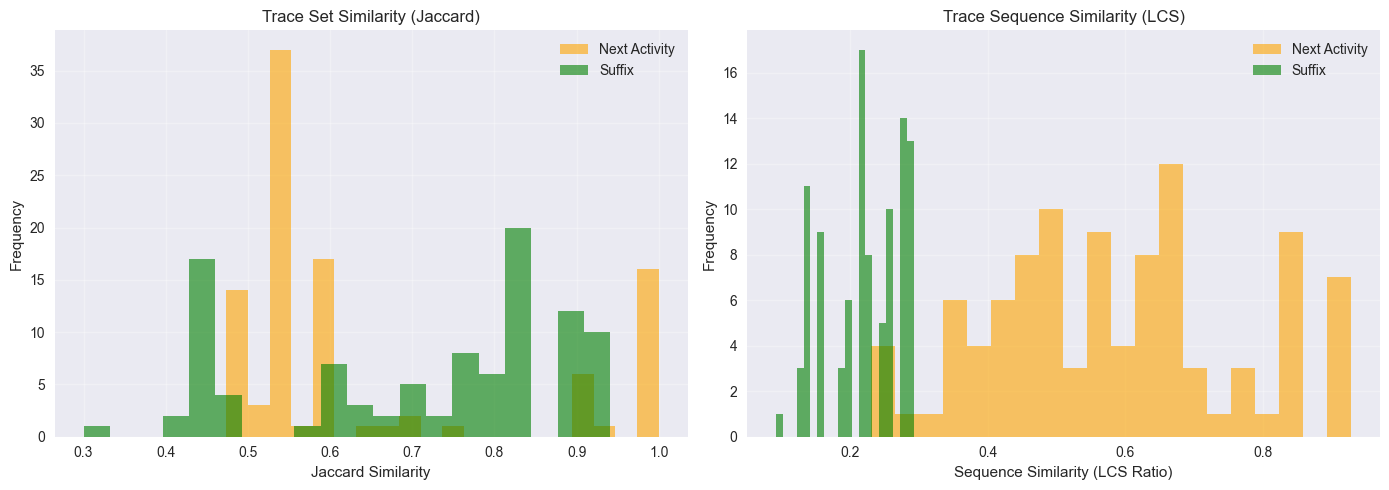

In [10]:
def jaccard_similarity(set1: set, set2: set) -> float:
    """Calculate Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

def trace_similarity(trace1: List[str], trace2: List[str]) -> float:
    """Calculate similarity between two traces (set-based Jaccard)."""
    set1 = set(trace1)
    set2 = set(trace2)
    return jaccard_similarity(set1, set2)

def sequence_similarity(trace1: List[str], trace2: List[str]) -> float:
    """Calculate sequence similarity (longest common subsequence ratio)."""
    def lcs_length(s1, s2):
        m, n = len(s1), len(s2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if s1[i-1] == s2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        return dp[m][n]
    
    lcs = lcs_length(trace1, trace2)
    max_len = max(len(trace1), len(trace2))
    return lcs / max_len if max_len > 0 else 0.0

# Sample original traces for comparison
sample_size = min(100, len(original_sequences_clean))
sample_original = original_sequences_clean[:sample_size]

# Calculate similarities for next activity model
if next_activity_traces:
    next_activity_similarities = []
    next_activity_seq_similarities = []
    
    for i in range(min(sample_size, len(next_activity_traces))):
        orig_trace = sample_original[i]
        gen_trace = next_activity_traces[i]
        
        sim = trace_similarity(orig_trace, gen_trace)
        seq_sim = sequence_similarity(orig_trace, gen_trace)
        
        next_activity_similarities.append(sim)
        next_activity_seq_similarities.append(seq_sim)
    
    print("Next Activity Model Similarity Metrics:")
    print(f"  Average Jaccard similarity: {np.mean(next_activity_similarities):.3f}")
    print(f"  Average sequence similarity: {np.mean(next_activity_seq_similarities):.3f}")

# Calculate similarities for suffix model
if suffix_traces:
    suffix_similarities = []
    suffix_seq_similarities = []
    
    for i in range(min(sample_size, len(suffix_traces))):
        orig_trace = sample_original[i]
        gen_trace = suffix_traces[i]
        
        sim = trace_similarity(orig_trace, gen_trace)
        seq_sim = sequence_similarity(orig_trace, gen_trace)
        
        suffix_similarities.append(sim)
        suffix_seq_similarities.append(seq_sim)
    
    print("\nSuffix Model Similarity Metrics:")
    print(f"  Average Jaccard similarity: {np.mean(suffix_similarities):.3f}")
    print(f"  Average sequence similarity: {np.mean(suffix_seq_similarities):.3f}")

# Plot similarity distributions
if (next_activity_traces or suffix_traces):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Jaccard similarity
    if next_activity_traces:
        axes[0].hist(next_activity_similarities, bins=20, alpha=0.6, label='Next Activity', color='orange')
    if suffix_traces:
        axes[0].hist(suffix_similarities, bins=20, alpha=0.6, label='Suffix', color='green')
    axes[0].set_xlabel('Jaccard Similarity')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Trace Set Similarity (Jaccard)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Sequence similarity
    if next_activity_traces:
        axes[1].hist(next_activity_seq_similarities, bins=20, alpha=0.6, label='Next Activity', color='orange')
    if suffix_traces:
        axes[1].hist(suffix_seq_similarities, bins=20, alpha=0.6, label='Suffix', color='green')
    axes[1].set_xlabel('Sequence Similarity (LCS Ratio)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Trace Sequence Similarity (LCS)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 10. Summary Statistics

Generate a summary comparison table.


In [11]:
# Create summary statistics
summary_data = {
    'Metric': [
        'Number of Traces',
        'Mean Case Length',
        'Median Case Length',
        'Std Case Length',
        'Unique Activities',
        'Total Activity Count',
    ],
    'Original': [
        len(original_sequences_clean[:NUM_TRACES_TO_GENERATE]),
        f"{np.mean(original_lengths):.2f}",
        f"{np.median(original_lengths):.2f}",
        f"{np.std(original_lengths):.2f}",
        len(original_activity_counts),
        total_original,
    ],
}

if next_activity_traces:
    summary_data['Next Activity'] = [
        len(next_activity_traces),
        f"{np.mean(next_activity_lengths):.2f}",
        f"{np.median(next_activity_lengths):.2f}",
        f"{np.std(next_activity_lengths):.2f}",
        len(next_activity_counts),
        total_next_activity,
    ]
    
    # Add similarity metrics if calculated
    if 'next_activity_similarities' in locals():
        summary_data['Metric'].extend([
            'Avg Jaccard Similarity',
            'Avg Sequence Similarity',
        ])
        summary_data['Original'].extend(['-', '-'])
        summary_data['Next Activity'].extend([
            f"{np.mean(next_activity_similarities):.3f}",
            f"{np.mean(next_activity_seq_similarities):.3f}",
        ])

if suffix_traces:
    if 'Next Activity' not in summary_data:
        summary_data['Next Activity'] = ['-'] * len(summary_data['Metric'])
    
    summary_data['Suffix'] = [
        len(suffix_traces),
        f"{np.mean(suffix_lengths):.2f}",
        f"{np.median(suffix_lengths):.2f}",
        f"{np.std(suffix_lengths):.2f}",
        len(suffix_counts),
        total_suffix,
    ]
    
    # Add similarity metrics if calculated
    if 'suffix_similarities' in locals():
        if 'Avg Jaccard Similarity' not in summary_data['Metric']:
            summary_data['Metric'].extend([
                'Avg Jaccard Similarity',
                'Avg Sequence Similarity',
            ])
            summary_data['Original'].extend(['-', '-'])
            if 'Next Activity' in summary_data:
                summary_data['Next Activity'].extend(['-', '-'])
        
        summary_data['Suffix'].extend([
            f"{np.mean(suffix_similarities):.3f}",
            f"{np.mean(suffix_seq_similarities):.3f}",
        ])
    elif len(summary_data['Suffix']) < len(summary_data['Metric']):
        summary_data['Suffix'].extend(['-'] * (len(summary_data['Metric']) - len(summary_data['Suffix'])))

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)



SUMMARY COMPARISON
                 Metric Original Next Activity Suffix
       Number of Traces     1000          1000   1000
       Mean Case Length    19.39         14.00  65.00
     Median Case Length    18.00         14.00  65.00
        Std Case Length     6.58          0.00   0.00
      Unique Activities       25            12     17
   Total Activity Count    19387         14000  65000
 Avg Jaccard Similarity        -         0.642  0.713
Avg Sequence Similarity        -         0.587  0.222
